# Skin Cancer Detection using Deep Learning
This Jupyter notebook demonstrates how to build a deep learning model for skin cancer detection using the Xception architecture. The model classifies skin lesion images as either benign or malignant.

## Prerequisites

### Experiments
This project utilises Weights & Biases (wandb) to experiment various model configurations. To perform experiments with different configurations, you need to follow the following steps first:

- Create a wandb account at [wandb.ai](https://wandb.ai) if you don't have one yet
- Get your Wandb API key from your account settings
- Add your Wandb API key in the `.env` file with the key `WANDB_API_KEY`
- If the `.env` file doesn't exist, copy the `.env.example` file to create `.env` and replace the placeholder with your actual API key

### Environment Setup
Install the required packages from `requirements.txt` file.

### Notebook Structure
This notebook is organized into the following sections:
- Import Libraries - Required Python packages for the project
- Constants - Define paths and other constants
- Load Metadata - Load and explore the updated metadata
- Split Training and Testing Set - Prepare data splits
- Prepare Dataset - Custom dataset class for loading images
- Data Augmentation - Apply transformations to improve model generalization
- Create Data Loaders - Batch data loading for training
- Train the Model - Functions for model training and validation
- Save/Load the Model - Utilities to persist trained models
- Test the Model - Evaluate model performance
- Experiments - Run training with specific configurations

## Import Libraries

In [ ]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
import wandb
from wandb.sdk.wandb_run import Run

# Local imports
from scd.utils.common import get_model, load_datasets

c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

In [2]:
num_classes = 2 # Malignant and Benign
random_state = 42
model_type = 'ViT'

# Define paths
root_path = Path.cwd().parent
model_dir = root_path / 'models'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Datasets

In [3]:
save_dir = root_path / 'data' / 'processed' / model_type

# Load the saved datasets
train_tensor_dataset, val_tensor_dataset, test_tensor_dataset = load_datasets(save_dir)

# Create DataLoader objects
batch_size = 32
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

## Get Environment Variables

In [4]:
# Load environment variables
load_dotenv()
WANDB_API_KEY = os.getenv('WANDB_API_KEY')
WANDB_ENTITY = os.getenv('WANDB_ENTITY')
WANDB_PROJECT = os.getenv('WANDB_PROJECT')

## Train the Model

### Train Epoch

The `train_epoch` function handles one complete training cycle through all batches in the training dataset. It tracks key metrics and reports them to Weights & Biases if an experiment run is provided for logging, enabling experiment tracking and visualisation.

In [ ]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimiser: torch.optim.Optimizer, epochs: int, current_epoch: int, wandb_run: Run = None, phase: str = 'Training') -> tuple:
    """
    Train the model for one epoch.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    train_loader : DataLoader
        DataLoader for the training dataset.
    criterion : nn.Module
        Loss function to compute the loss.
    optimiser : torch.optim.Optimizer
        Optimiser for updating model weights.
    epochs : int
        Total number of epochs for training.
    current_epoch : int
        Current epoch number.
    wandb_run : Run, optional
        Weights & Biases run object for logging metrics. Defaults to None.
    phase : str, optional
        Phase of training, e.g., 'Training' or 'Fine-tuning'. Defaults to 'Training
    
    Returns
    -------
    tuple
        A tuple containing the mean loss and accuracy for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    # Create progress bar for this epoch
    train_pbar = tqdm(train_loader, desc=f"Epoch [{current_epoch+1}/{epochs}]", ncols=120)
    
    # Training loop
    for i, (images, labels) in enumerate(train_pbar):
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimiser.zero_grad()
        
        # Forward pass
        outputs = model(images)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        # Compute loss
        loss = criterion(logits, labels)
        
        # Back propagation
        loss.backward()
        
        # Update weights
        optimiser.step()
        
        # Update statistics
        running_loss += loss.item()
        mean_loss = running_loss / (i + 1)
        
        # Calculate accuracy
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        # Log metrics to Weights & Biases
        if wandb_run:
            wandb_run.log({
                'train_loss': mean_loss,
                'train_accuracy': accuracy,
                'epoch': current_epoch + 1,
                'phase': phase
            })

        # Update progress bar with training metrics    
        train_pbar.set_postfix({
            'loss': f'{mean_loss:.4f}', 
            'acc': f'{accuracy:.2f}%',
        })
    
    # Return the mean loss and accuracy for the epoch
    return mean_loss, accuracy

### Validate Epoch

The `validate_epoch` function evaluates the model's performance on validation data during training. It measures metrics like loss, accuracy, and ROC AUC score to track how well the model generalizes to unseen data. This function is crucial for monitoring model performance, detecting overfitting, and determining when to stop training or adjust hyperparameters.

In [6]:
def validate_epoch(model: nn.Module, val_loader: DataLoader, criterion: nn.Module, epoch: int, wandb_run: Run = None, phase:str = 'Validation') -> tuple:
    """
    Validate the model for one epoch.

    Parameters
    ----------
    model : nn.Module
        The model to validate.
    val_loader : DataLoader
        DataLoader for the validation dataset.
    criterion : nn.Module
        Loss function to compute the loss.
    epoch : int
        Current epoch number.
    wandb_run : Run, optional
        Weights & Biases run object for logging metrics. Defaults to None.
    phase : str, optional
        Phase of validation, e.g., 'Validation' or 'Testing'. Defaults to 'Validation'.
    
    Returns
    -------
    tuple
        A tuple containing the average validation loss and accuracy.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss and accuracy
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_preds = []

    # Create progress bar for validation
    val_pbar = tqdm(val_loader, desc=phase, ncols=120)

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Validation loop
        for images, labels in val_pbar:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            # Collect labels and predictions for ROC_AUC Score
            loss = criterion(logits, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * val_correct / val_total

            # Collect labels and predictions for ROC_AUC Score
            all_labels.append(labels)
            all_preds.append(predicted)

            # Update progress bar with validation metrics
            val_pbar.set_postfix({
                'val_loss': f'{avg_val_loss:.4f}', 
                'val_acc': f'{val_accuracy:.2f}%'
            })
    
    # Calculate average loss, accuracy, and ROC_AUC Score
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    auc = roc_auc_score(
        np.concatenate(all_labels), 
        np.concatenate(all_preds)
    )

    # Log validation metrics
    if wandb_run:
        log_dict = {
            f'{phase.lower()}_loss': avg_val_loss,
            f'{phase.lower()}_accuracy': val_accuracy,
            f'{phase.lower()}_auc': auc,
            'epoch': epoch + 1,
            'phase': phase
        }
        wandb_run.log(log_dict)
    
    # Return average validation loss and accuracy
    return avg_val_loss, val_accuracy

### Fine-Tuning

Fine-tuning is a critical technique in transfer learning where we take a pre-trained model and selectively retrain some of its layers to adapt it to our specific task. The `fine_tuning()` function implements this technique for skin cancer classification by:

1. **Selective Layer Freezing**: The function freezes early layers of the Xception model that have learned general visual features, while unfreezing later layers (blocks 11, 12, conv3, conv4, and fc) to allow adaptation to skin lesion characteristics.

2. **Differential Learning Rates**: The function applies smaller learning rates to the middle layers and a higher learning rate (10x) to the final classification layer, enabling fine-grained parameter updates according to each layer's role.

3. **Early Stopping**: Training automatically stops when validation loss fails to improve for a specified number of epochs, preventing overfitting and saving computational resources.

This approach leverages the general feature extraction capabilities already learned by the model from ImageNet while specializing the deeper layers for distinguishing between benign and malignant skin lesions, achieving better performance than either training from scratch or using the pre-trained model without adaptation.

In [7]:
def fine_tuning(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, criterion: nn.Module, epochs: int = 5, patience: int = 5, learning_rate: float = 1e-4, wandb_run: Run = None) -> None:
    """
    Fine-tune the model on the training dataset with early stopping.

    Parameters
    ----------
    model : nn.Module
        The pre-trained model to fine-tune.
    train_loader : DataLoader
        DataLoader for the training dataset.
    val_loader : DataLoader
        DataLoader for the validation dataset.
    criterion : nn.Module
        Loss function to compute the loss.
    epochs : int, optional
        Number of epochs for fine-tuning. Defaults to 10.
    patience : int, optional
        Number of epochs with no improvement after which training will be stopped. Defaults to 5.
    learning_rate : float, optional
        Learning rate for the optimizer. Defaults to 1e-4.
    wandb_run : Run, optional
        Weights & Biases run object for logging metrics. Defaults to None.
    """
    # Initialise the best validation loss and counter for fine-tuning
    best_val_loss = float('inf')
    counter = 0

    # Freeze all layers except the last few blocks for fine-tuning
    for name, param in model.named_parameters():
        if any(layer in name for layer in ['block11', 'block12', 'conv3', 'conv4', 'fc']):
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Define a new optimizer for fine-tuning
    optimiser = torch.optim.Adam([
        {"params": model.block11.parameters(), "lr": learning_rate},
        {"params": model.block12.parameters(), "lr": learning_rate},
        {"params": model.conv3.parameters(), "lr": learning_rate},
        {"params": model.conv4.parameters(), "lr": learning_rate},
        {"params": model.fc.parameters(), "lr": learning_rate * 10}
    ])

    # Fine-tuning loop with early stopping
    for epoch in range(epochs):
        _, _ = train_epoch(model, train_loader, criterion, optimiser, epochs, wandb_run=wandb_run, current_epoch=epoch, phase='Fine-tuning')
        val_loss, _ = validate_epoch(model, val_loader, criterion, epochs, wandb_run=wandb_run, phase='Fine-tuning Validation')

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

### Train Model

The `train_model()` function orchestrates the entire training process for skin cancer classification models. This function:

1. **Model Preparation**:
  - Moves the model to the appropriate device (CPU/GPU)
  - Initializes the Adam optimizer with the specified learning rate

2. **Loss Function Configuration**:
  - Optionally applies class weighting to address dataset imbalance
  - Uses CrossEntropyLoss or can be configured to use FocalLoss

3. **Training Process Management**:
  - Implements early stopping to prevent overfitting
  - Tracks best validation performance
  - Logs metrics to Weights & Biases for experiment tracking

4. **Fine-tuning Support**:
  - Optionally enables fine-tuning after initial training
  - Uses a selective layer unfreezing approach with differential learning rates

The function provides a comprehensive framework for training deep learning models on skin lesion datasets, with flexibility for experimenting with various training strategies and hyperparameters.

In [8]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 5, learning_rate: float = 1e-3, fine_tune: bool = False, use_class_weights: bool = True, wandb_run: Run = None) -> None:
    """
    Train the model with feature extraction and optional fine-tuning.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    train_loader : DataLoader
        DataLoader for the training dataset.
    val_loader : DataLoader
        DataLoader for the validation dataset.
    epochs : int, optional
        Number of epochs to train the model. Defaults to 5.
    learning_rate : float, optional
        Learning rate for the optimizer. Defaults to 1e-3.
    fine_tune : bool, optional
        Whether to fine-tune the model after feature extraction. Defaults to False.
    use_class_weights : bool, optional
        Whether to use class weights in the loss function. Defaults to True.
    wandb_run : Run, optional
        Weights & Biases run object for logging metrics. Defaults to None.
    """
    
    # Set the device for training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device
    model = model.to(device)

    # Initialise the optimiser
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)

    # Set up early stopping parameters
    patience = 5
    best_val_loss = float('inf')
    counter = 0

    # Check if class weights should be used
    if use_class_weights:
        # Extract labels from the train_loader
        all_labels = []
        for _, labels in train_loader:
            all_labels.append(labels.cpu().numpy())
        train_labels = np.concatenate(all_labels)

        # Compute class weights using the labels
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

        # Define the loss function with class weights
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        # Define the loss function without class weights
        criterion = nn.CrossEntropyLoss()
    
    criterion = criterion.to(device)

    if fine_tune:
        # Unfreeze only the classifier
        for param in model.fc.parameters():
            param.requires_grad = True

    # Training loop
    for epoch in range(epochs):
        _, _ = train_epoch(model, train_loader, criterion, optimiser, epochs, current_epoch=epoch, wandb_run=wandb_run)
        val_loss, _ = validate_epoch(model, val_loader, criterion, epochs, wandb_run=wandb_run)  

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break


    # Fine-tuning the model
    if fine_tune:
        print('\n' + '#' * 50)
        print("Starting fine-tuning...")
        print('#' * 50, '\n')

        fine_tuning(
            model, 
            train_loader, 
            val_loader, 
            criterion, 
            epochs=epochs, 
            patience=patience, 
            learning_rate=learning_rate, 
            wandb_run=wandb_run
        )

## Save the Model

The `save_model()` function persists trained deep learning models to disk for future use. It ensures that models are preserved after training, allowing for later inference without retraining. The function:

In [9]:
def save_model_weights(model: nn.Module, model_dir: str, model_name: str) -> None:
    """
    Save the trained model to the specified directory.

    Parameters
    ----------
    model : nn.Module
        The trained model to save.
    model_dir : str
        Directory where the model will be saved.
    model_name : str
        Name of the model file to save (e.g., 'model.pth').
    """
    # Ensure the model directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = Path(model_dir) / model_name

    # Save the model state dictionary
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

## Load the Model

The `load_model()` function restores a previously trained model from disk for inference or further training. This enables model reuse without retraining, which is especially valuable for computationally expensive deep learning models.


In [10]:
def load_model(model: nn.Module, model_path: str) -> nn.Module:
    """
    Load the pre-trained model weights.

    Parameters
    ----------
    model : nn.Module
        The model architecture to load weights into.
    model_path : str
        Path to the saved model weights.

    Returns
    -------
    nn.Module
        The model with loaded weights.
    """
    # Check if the model path exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    
    # Load the model state dictionary
    model.load_state_dict(torch.load(model_path))

    # Move the model to the appropriate device and return
    return model.to(device)

## Test the Model

The `test_model()` function evaluates the performance of a trained deep learning model on unseen data. This function:

1. **Performs Inference on Test Data**:
  - Sets the model to evaluation mode to disable dropout and batch normalisation updates
  - Processes the test dataset batch by batch
  - Collects model predictions and ground truth labels

2. **Calculates Performance Metrics**:
  - Classification report with precision, recall, and F1-score for each class
  - Confusion matrix to visualise true positives, false positives, true negatives, and false negatives
  - ROC AUC score to evaluate the model's discriminative ability

3. **Visualization and Reporting**:
  - Generates a visual heatmap of the confusion matrix
  - Formats and prints classification metrics for easy interpretation

4. **Optional Experiment Tracking**:
  - When provided with a Weights & Biases run object, logs all metrics and visualisations
  - Supports detailed experiment comparison and model versioning

This comprehensive evaluation helps determine the model's effectiveness at identifying malignant skin lesions and provides insights for potential improvements.



In [11]:
def test_model(model: nn.Module, test_loader: DataLoader, wandb_run: Run = None) -> None:
    """
    Test the model on the test dataset and log results.

    Parameters
    ----------
    model : nn.Module
        The trained model to evaluate.
    test_loader : DataLoader
        DataLoader for the test dataset.
    wandb_run : Run, optional
        Weights & Biases run object for logging. Defaults to None.
    """
    # Initialize lists to store predictions and labels
    all_preds = []
    all_labels = []

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        # Loop through the test set
        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            # Get predictions
            preds = torch.argmax(logits, dim=1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Compute ROC_AUC Score
    auc = roc_auc_score(all_labels, all_preds) 
    print('ROC AUC Score:', auc)

    # Log confusion matrix to Weights & Biases
    if wandb_run:
        wandb_run.log({
            'classification_report': wandb.Table(dataframe=pd.DataFrame(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant'], output_dict=True)).transpose()),
            'confusion_matrix': wandb.plot.confusion_matrix(
                probs=None,
                y_true=all_labels,
                preds=all_preds,
                class_names=['Benign', 'Malignant']
            ),
            'accuracy': np.mean(np.array(all_preds) == np.array(all_labels)),
            'roc_auc_score': auc
        })

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

## Create an Experiment

The `create_wandb_experiment()` function integrates our skin cancer detection model with Weights & Biases (W&B) for experiment tracking. This function:

1. **Initialises W&B Experiment**: Creates a new experiment run with the provided name
2. **Configures Experiment Parameters**: Registers hyperparameters and settings in the W&B dashboard
3. **Establishes Project Context**: Links the experiment to our skin cancer detection project
4. **Handles Authentication**: Uses the API key from environment variables to access W&B services
5. **Returns Control Object**: Provides a run object for logging metrics throughout model training

This integration enables systematic tracking of model performance, visualisation of results, and comparison of different experimental configurations, which is essential for methodical research in deep learning applications for medical image analysis.

In [12]:
def create_wandb_experiment(name:str, config: dict) -> Run:
    """
    Function to create experiment to log the model and metrics to Weights & Biases.

    Parameters
    ----------
    name : str
        Name of the experiment run.
    config : dict
        Configuration dictionary containing hyperparameters and other settings.
    
    Returns
    -------
    wandb.run : Run
        A Weights & Biases run object for logging metrics and artifacts.
    """

    return wandb.init(
        # Set the wandb entity and project name
        entity=WANDB_ENTITY,
        project=WANDB_PROJECT,

        # Set the name of the run
        name=name,

        # Set the configuration for the run
        config=config,
    )

## Experiments

The `experiment()` function allows us to systematically run experiments with different configurations of our skin cancer detection model. Using this function, we can:

1. **Explore Different Data Augmentation Techniques**
  - Control image transformations such as random flips, affine transformations, and color adjustments
  - Evaluate the impact of augmentation strategies on model performance

2. **Optimise Hyperparameters**
  - Experiment with learning rates, batch sizes, and training epochs
  - Test the effects of class weighting for handling dataset imbalance

3. **Compare Training Approaches**
  - Evaluate the impact of fine-tuning versus feature extraction
  - Assess different model architectures for skin cancer classification

4. **Track Performance Metrics**
  - All experiments are logged to Weights & Biases for visualisation and comparison
  - Performance is evaluated using accuracy, loss, and ROC AUC scores

This systematic experimentation approach helps identify the optimal model configuration for skin cancer detection, balancing accuracy, generalisation, and computational efficiency.

In [13]:
def experiment(model: nn.Module, data_loaders: tuple, hyperparameters: dict = {}, experiment_name: str = 'experiment', save_model: bool = False, save_model_as: str = 'model.pth') -> None:
    """
    Main function to run the skin cancer classification experiment.

    Parameters
    ----------
    model: nn.Module
        Model to experiment with
    data_loaders : tuple
        Tuple containing DataLoader objects for training, validation, and testing datasets.
    hyperparameters : dict, optional
        Dictionary containing hyperparameters for training. Defaults to an empty dictionary.
    experiment_name : str, optional
        Name of the experiment for logging purposes. Defaults to 'experiment'.
    save_model : bool, optional
        Whether to save the trained model. Defaults to False.
    save_model_as : str, optional
        Name of the file to save the model as. Defaults to 'model.pth'.
    """
    # Create a Weights & Biases experiment
    run = create_wandb_experiment(
        name=experiment_name,
        config=hyperparameters
    )

    # Unpack the data loaders
    train_loader, val_loader, test_loader = data_loaders

    # Train the model
    print('#' * 50)
    print("Training the model...")
    print('#' * 50, '\n')
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=hyperparameters['epochs'],
        learning_rate=hyperparameters['learning_rate'],
        use_class_weights=hyperparameters['use_class_weights'],
        fine_tune=hyperparameters['fine_tune'],
        wandb_run=run,
    )

    # Test the model
    print('\n\n' + '#' * 50)
    print("Testing the model...")
    print('#' * 50, '\n')
    test_model(
        model=model,
        test_loader=test_loader,
        wandb_run=run
    )

    # Save the model
    if save_model:
        print('#' * 50)
        print("Saving the model...")
        print('#' * 50, '\n')
        save_model_weights(
            model=model,
            model_dir=model_dir,
            model_name=save_model_as
        )
    
    # Finish the Weights & Biases run
    run.finish()

# Model Architecture Analysis

In this section, we analyse the architecture of our pre-trained models for skin cancer detection with various configurations.

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: avishekdangol (the_lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


##################################################
Training the model...
################################################## 



Validation: 100%|████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it, val_loss=0.8481, val_acc=80.15%]




##################################################
Testing the model...
################################################## 

              precision    recall  f1-score   support

      Benign       0.81      0.91      0.85        97
   Malignant       0.61      0.40      0.48        35

    accuracy                           0.77       132
   macro avg       0.71      0.65      0.67       132
weighted avg       0.75      0.77      0.76       132

ROC AUC Score: 0.6536082474226804


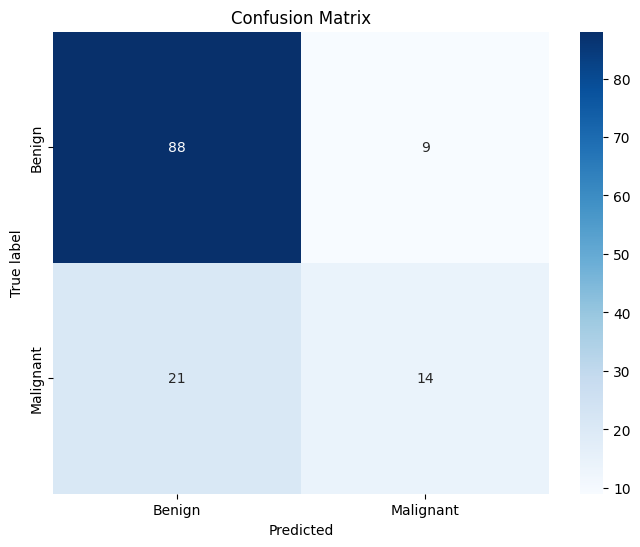

##################################################
Saving the model...
################################################## 



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Model saved to c:\Users\dango\OneDrive - UWE Bristol\projects\thesis-project\models\ViT16-class_weights.pth


accuracy,▁
epoch,▁▁▁▁▁▁█▂▂▂▂▂▂▂▂▂█▄▄▄▄▄▄▄█▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇
roc_auc_score,▁
train_accuracy,▁▃▃▄▄▄▄▄▇▇▇▇▇▇▇▇▇███████████████████████
train_loss,█████▇▇▇▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▄▁█▇█
validation_auc,▁▇██▇
validation_loss,▂▁▅▆█
accuracy,0.77273
epoch,6
phase,Validation


In [14]:
model = get_model('ViT')

# Initialise the constants
experiment_name = 'ViT16-class_weights'

hyperparameters = {
    'epochs': 5,
    'learning_rate': 1e-4,
    'batch_size': batch_size,
    'use_class_weights': True,
    'fine_tune': False,
    'type': 'initial-training'
}

# Perform the experiment
experiment(
    model=model,
    data_loaders=(train_loader, val_loader, test_loader),
    hyperparameters=hyperparameters,
    experiment_name=experiment_name,
    save_model=True,
    save_model_as=f'{experiment_name}.pth'
)